In [3]:
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Script to run and export ISSM relaxation
# Mikayla Pascual 07/13/22
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#import 
from MatlabFuncs import *
from model import *
from triangle import *
from bamg import bamg
from savevars import *
import plotdoc
from loadmodel import *
from os.path import exists

from scipy.io import loadmat
from m1qn3inversion import *
import numpy as np
from ContourToNodes import *
from solve import *

import lhsmdu #install in terminal 'pip install lhsmdu'
import matplotlib.pyplot as plt
import numpy as np
import pickle



could not import shapefile, PyShp has not been installed, no shapefile reading capabilities enabled


In [4]:
# Load some mat files to use later
vel_mat = loadmat('Cheat_matfiles/vel.mat')
hmaxVertices_mat = loadmat('Cheat_matfiles/hmaxVertices.mat')
param_mat = loadmat('Cheat_matfiles/param.mat')

velx = vel_mat['velx']
vely = vel_mat['vely']
vel = vel_mat['vel']

hmaxVertices = hmaxVertices_mat['hmaxVertices']


In [5]:
# Setup
region = 'SAtoES';
start_year = 1985;

# Mesh sizing
triangleresolution = 1000;
hmin = 300;
hmax = 10000;

# Mesh
md = model()
md = triangle(md,'./Exp/' +region+ '.exp',triangleresolution) # set up mesh

md = bamg(md,'hmin',hmin,'hmax',hmax,'field',vel,'err',2,'hmaxVertices',hmaxVertices);

#savevars('./Models/' +region+ '_mesh', 'md', md)

# 

In [6]:
# Load parameters
md.geometry.bed = param_mat['geometry_bed']
md.geometry.surface = param_mat['geometry_surface']
md.geometry.base = param_mat['geometry_base']
md.mask.ice_levelset = param_mat['mask_ice_levelset']
md.mask.groundedice_levelset = param_mat['mask_groundedice_levelset']
md.inversion.vx_obs = param_mat['inversion_vx_obs']
md.inversion.vy_obs = param_mat['inversion_vy_obs']
md.inversion.vel_obs = param_mat['inversion_vel_obs']
md.initialization.vx = param_mat['initialization_vx']
md.initialization.vy = param_mat['initialization_vy']
md.initialization.vz = param_mat['initialization_vz']
md.initialization.vel = param_mat['initialization_vel']
md.friction.coefficient = param_mat['friction_coefficient']
md.materials.rheology_n = param_mat['rheology_n']
md.materials.rheology_B = param_mat['rheology_B']
md.basalforcings.groundedice_melting_rate = param_mat['basalforcings_groundedice_melting_rate']
md.basalforcings.floatingice_melting_rate = param_mat['basalforcings_floatingice_melting_rate']
md.smb.mass_balance = param_mat['smb_mass_balance']
md.basalforcings.geothermalflux = param_mat['basalforcings_geothermalflux']
md.stressbalance.spcvx = param_mat['stressbalance_spcvx']
md.stressbalance.spcvy = param_mat['stressbalance_spcvy']
md.stressbalance.spcvz = param_mat['stressbalance_spcvz']
md.stressbalance.referential = param_mat['stressbalance_referential']
md.stressbalance.loadingforce = param_mat['stressbalance_loadingforce']
md.masstransport.spcthickness = param_mat['masstransport_spcthickness']

# Set bed = base for grounded ice
md.geometry.base = md.geometry.bed
md.geometry.thickness = md.geometry.surface - md.geometry.base

md.friction.q = np.ones(md.mesh.numberofelements)
md.friction.p = np.ones(md.mesh.numberofelements)

md.flowequation.isSSA = 1
md.flowequation.vertex_equation = 2 * np.ones(md.mesh.numberofvertices)
md.flowequation.element_equation = 2 * np.ones(md.mesh.numberofelements)
md.flowequation.borderSSA = np.ones(md.mesh.numberofvertices)
md.flowequation.borderHO = np.ones(md.mesh.numberofvertices)
md.flowequation.borderFS = np.ones(md.mesh.numberofvertices)

md.mask.ocean_levelset = -md.mask.ice_levelset

from generic import generic
md.cluster = generic() #telling where to run issm

md.miscellaneous.name = 'SAtoES'

In [7]:
md = loadmodel("inversion")

Opening inversion for reading 
solidearthsettings.solidearthsettings
lovenumbers.lovenumbers
rotational.rotational
results.solutionstep
empty init


TypeError: object of type 'float' has no len()

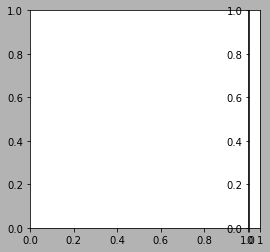

In [15]:
plotmodel(md, 'data', md.mask.ice_levelset)

In [6]:
## Relaxation
#Put results of inversion back into the model for forward runs
md.friction.coefficient=md.results.StressbalanceSolution.FrictionCoefficient
relaxation_years = 5 #try 5 years if 1 runs quickly

# Special post-processing of inverted friction coefficient
filename = 'Exp/' +region+ '_coeffront_after_inversion.exp'
if os.path.isfile(filename):
  pos = find(ContourToNodes(md.mesh.x, md.mesh.y, filename, 1))
  md.friction.coefficient[pos] = 10

md.initialization.pressure = np.zeros([md.mesh.numberofvertices,1])
md.initialization.temperature = 250*np.ones([md.mesh.numberofvertices,1])

# Set parameters
md.inversion.iscontrol=0;
md.timestepping.start_time = start_year;
md.timestepping.time_step  = .02;
md.timestepping.final_time = start_year + relaxation_years;
md.settings.output_frequency = (1/md.timestepping.time_step)/5; # 5/yr

In [7]:
# We set the transient parameters
md.transient.ismovingfront=0
md.transient.isthermal=0
md.transient.isstressbalance=1
md.transient.ismasstransport=1
md.transient.isgroundingline=1
md.groundingline.migration = 'SubelementMigration'

# We set the calving model (no moving front ... spclevelset is actually ignored)
md.levelset.spclevelset = md.levelset.spclevelset
md.calving.calvingrate = np.zeros([md.mesh.numberofvertices,1])
md.calving.meltingrate = np.zeros([md.mesh.numberofvertices,1])

# Set bed = base for grounded ice
#md.geometry.base = md.geometry.bed
#md.geometry.thickness = md.geometry.surface - md.geometry.base

# Set the requested outputs
md.stressbalance.requested_outputs=['default']
md.transient.requested_outputs=['default','IceVolumeAboveFloatation']

# Go solve
md.verbose.solution=1
md.cluster = generic()
md.settings.waitonlock = np.inf
md = solve(md,'transient')

checking model consistency
model not consistent: field mask.ice_levelset dimension  # 0 should be of size 12112


TypeError: no ice present in the domain

In [ ]:
from export_netCDF import export_netCDF
export_netCDF(md, "relaxation")